# MissForest Imputation for ThyroidDF

## Libraries

In [1]:
# %pip install scikit-learn==1.1.2
# %pip install scipy==1.9.1
# %pip install missingpy==0.2.0

In [2]:
import numpy as np
import pandas as pd
from utils.data_split import k_fold_split
from utils.comparison_utils import compare_imputations
from utils.forgetter import forget_random_col_per_sample
from utils.plotter import plot_col_histograms, plot_col_boxplots
from utils.category_utils import transform_categorical_columns, inverse_transform_categorical_columns, get_column_indices

In [3]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [4]:
import warnings
warnings.simplefilter('ignore')

## Data cleaning and preprocessing

In [5]:
qual_cols = { "age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG" }
cat_cols = { "sick", "referral_source", "on_antithyroid_meds", "lithium", "goitre", "tumor", "thyroid_surgery", "sex", "target", "on_thyroxine", "psych", "I131_treatment", "pregnant" }

In [6]:
remove_qual_cols = { "TBG" }
remove_cat_cols = { "referral_source" }

In [7]:
sel_qual_cols = list(qual_cols.difference(remove_qual_cols))
sel_cat_cols = list(cat_cols.difference(remove_cat_cols))
display(sel_qual_cols)
display(sel_cat_cols)

['TSH', 'FTI', 'T3', 'TT4', 'age', 'T4U']

['pregnant',
 'thyroid_surgery',
 'sick',
 'goitre',
 'psych',
 'I131_treatment',
 'on_thyroxine',
 'sex',
 'target',
 'lithium',
 'tumor',
 'on_antithyroid_meds']

In [8]:
df = pd.read_csv("./data/thyroidDF.csv")
df = df[(df["age"] >= 0) & (df["age"] < 100)]
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [9]:
transformed_nan_df, label_encoders = transform_categorical_columns(df, sel_cat_cols)
transformed_nan_df = transformed_nan_df[sel_cat_cols+sel_qual_cols]
transformed_nan_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,0,0,0,0,0,0,0,0,0,0,0,0,0.3,NaN,NaN,NaN,29,NaN
1,0,0,0,0,0,0,0,0,0,0,0,0,1.6,NaN,1.9,128.0,29,NaN
2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,41,NaN
3,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,36,NaN
4,0,0,0,0,0,0,0,0,31,0,0,0,NaN,NaN,NaN,NaN,32,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,0,0,0,0,0,0,0,1,0,0,0,0,NaN,77.0,NaN,64.0,56,0.83
9168,0,0,0,0,0,0,0,1,0,0,0,0,NaN,99.0,NaN,91.0,22,0.92
9169,0,0,0,0,0,0,0,1,16,0,0,0,NaN,89.0,NaN,113.0,69,1.27
9170,0,0,0,0,0,0,0,0,0,0,0,0,NaN,88.0,NaN,75.0,47,0.85


In [10]:
transformed_df = transformed_nan_df.dropna()
transformed_df.shape

(5981, 18)

## Train & Test split

In [11]:
k = 5

In [12]:
print(f"train: {transformed_df.shape[0] / k * (k-1)}\ntest: {transformed_df.shape[0] / k}")

train: 4784.8
test: 1196.2


In [13]:
train_df, test_df = k_fold_split(transformed_df, k)

## Select missing values

In [14]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1,
    "sick" : 1,
    "referral_source" : 1,
    "on_antithyroid_meds" : 1,
    "lithium" : 1,
    "goitre" : 1,
    "tumor" : 1,
    "thyroid_surgery" : 1,
    "sex" : 1,
    "target" : 1,
    "on_thyroxine" : 1,
    "psych" : 1,
    "I131_treatment" : 1,
    "pregnant" : 1,
    "target" : 1
}

In [15]:
seed = 1106
random_generator = np.random.default_rng(seed)

In [16]:
train_missing_vals_df, train_missing_col_map, train_missing_vals_idxs = forget_random_col_per_sample(train_df, weight_map, random_generator)
test_missing_vals_df, test_missing_col_map, test_missing_vals_idxs = forget_random_col_per_sample(test_df, weight_map, random_generator)

## MissForest Imputation

In [17]:
imputer = MissForest(missing_values=np.NaN, n_estimators=300)
X_train = train_missing_vals_df.to_numpy()
imputer = imputer.fit(X_train, cat_vars=get_column_indices(train_missing_vals_df, sel_cat_cols))
X_train_imputed = imputer.transform(X_train)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


### Results on training set

In [18]:
imputed_train_df = pd.DataFrame(X_train_imputed, columns=train_missing_vals_df.columns)
imputed_train_data_df = inverse_transform_categorical_columns(imputed_train_df.copy(), label_encoders)
imputed_train_data_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,t,f,f,f,f,f,f,NaN,R,f,f,f,11.599999,272.0,2.0,87.0,18.0,0.32
1,f,f,f,f,f,f,f,F,-,f,f,f,0.700000,75.0,1.6,70.0,84.0,0.93
2,f,f,f,f,f,f,f,F,F,f,f,f,52.683333,11.0,0.3,12.0,65.0,1.05
3,f,f,f,f,t,f,f,M,-,f,f,f,1.600000,59.0,1.7,67.0,34.0,1.15
4,f,f,f,f,f,f,f,M,-,f,f,f,3.500000,107.0,1.8,131.0,83.0,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,f,f,f,f,f,f,f,F,F,f,f,f,46.000000,49.0,1.0,48.0,67.0,0.98
4781,f,f,f,f,t,f,f,F,-,f,t,f,0.400000,114.0,2.4,103.0,19.0,0.91
4782,f,f,f,f,f,f,f,F,O,f,f,t,0.030000,46.0,2.3,42.0,24.0,0.92
4783,f,f,f,f,f,f,f,F,-,f,f,f,2.000000,78.0,2.6,87.0,43.0,1.13


In [19]:
train_results = compare_imputations(train_df, imputed_train_df)
train_results

,Column,MSE,RMSE,MAE
0,pregnant,0.000836,0.028913,0.000836
1,thyroid_surgery,0.000209,0.014456,0.000209
2,sick,0.002299,0.047946,0.002299
3,goitre,0.000209,0.014456,0.000209
4,psych,0.005225,0.072282,0.005225
5,I131_treatment,0.001254,0.035411,0.001254
6,on_thyroxine,0.003344,0.057825,0.003344
7,sex,0.021735,0.147427,0.018809
8,target,0.849112,0.921473,0.052874
9,lithium,0.001045,0.032325,0.001045


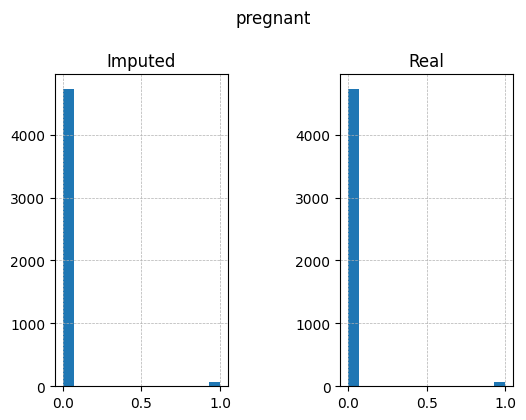

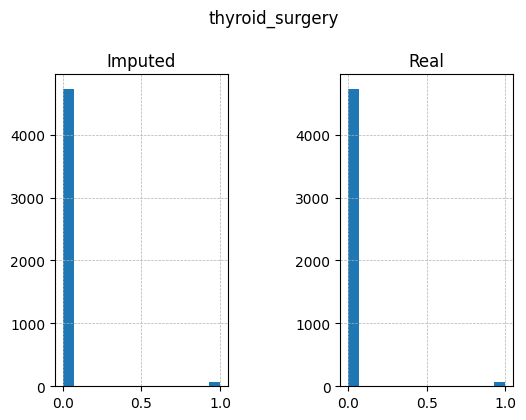

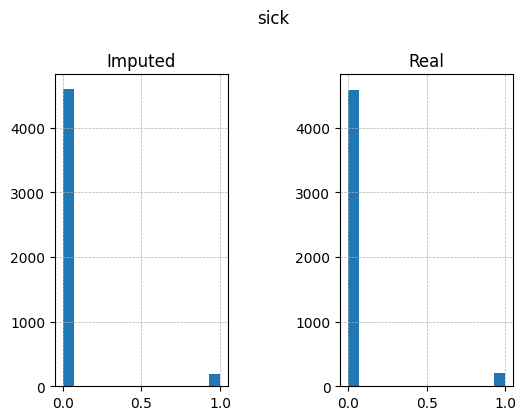

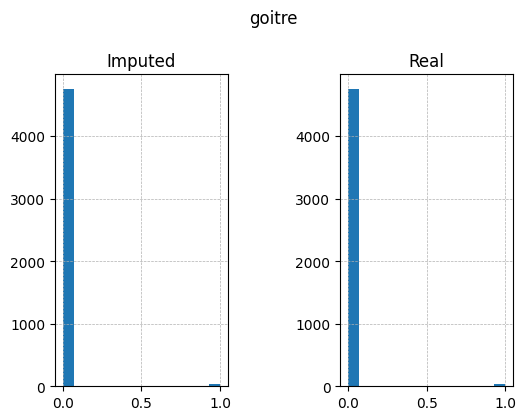

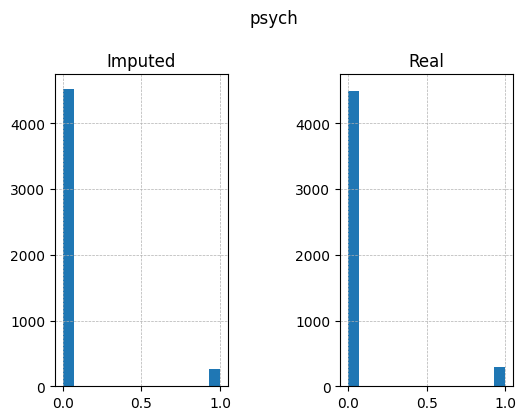

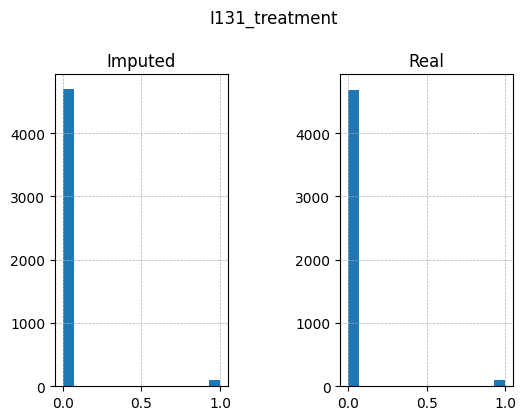

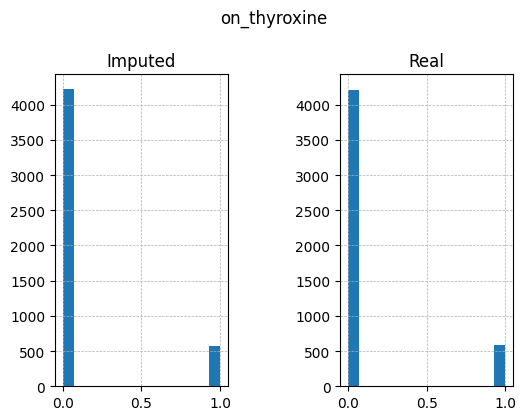

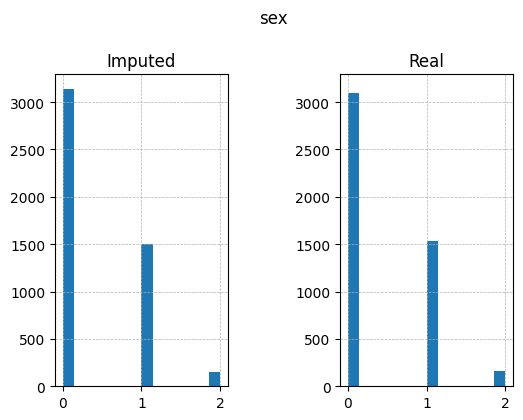

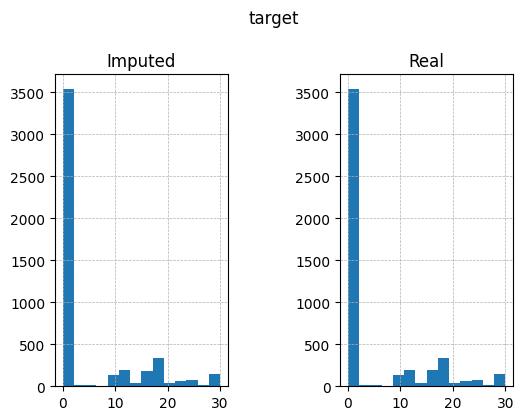

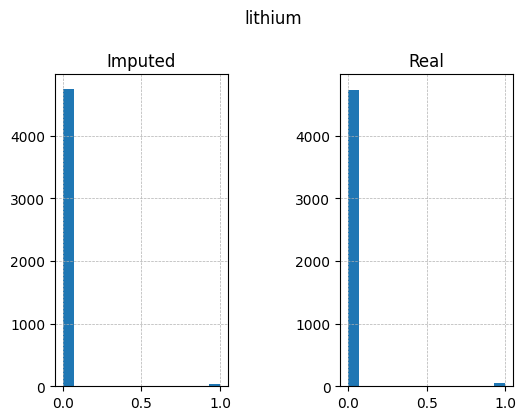

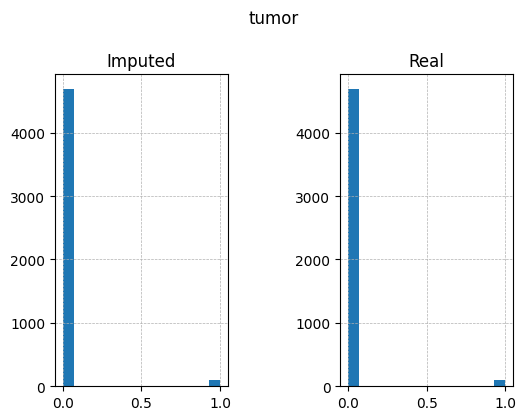

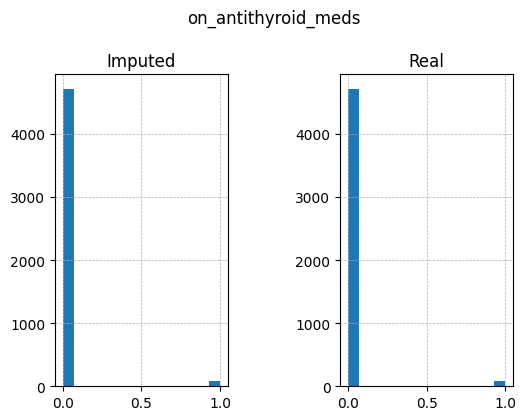

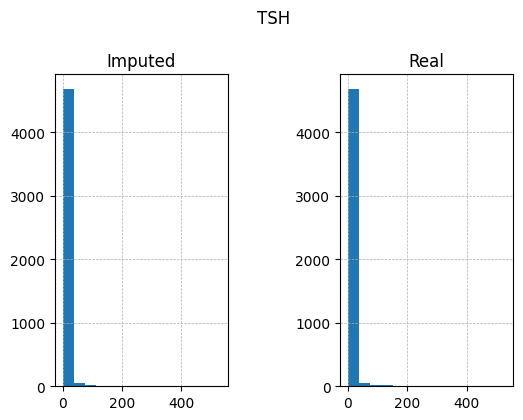

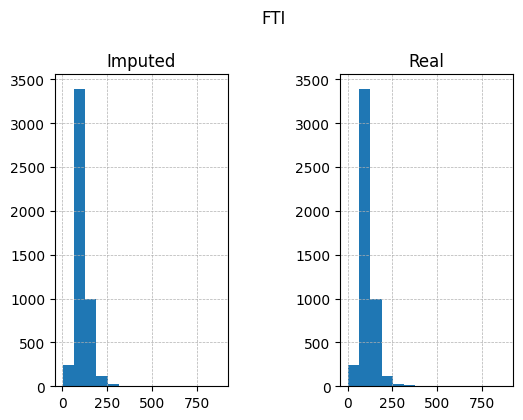

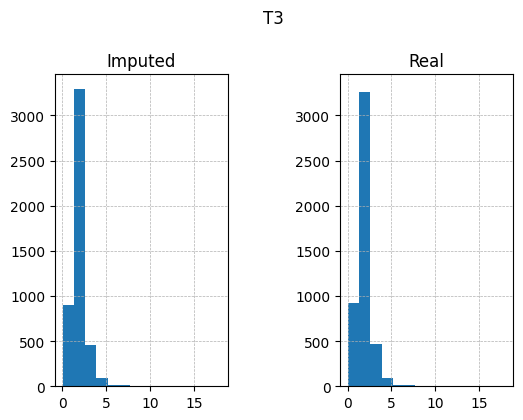

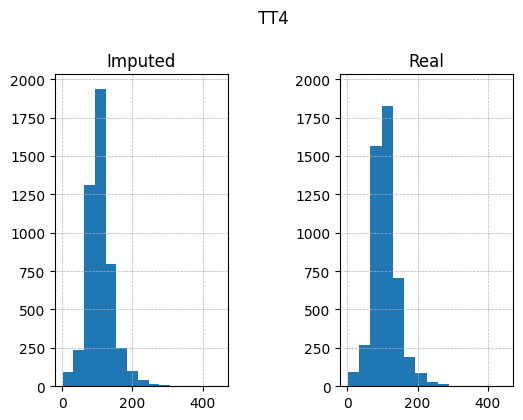

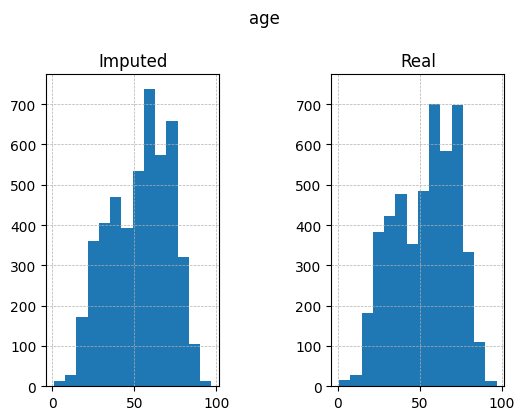

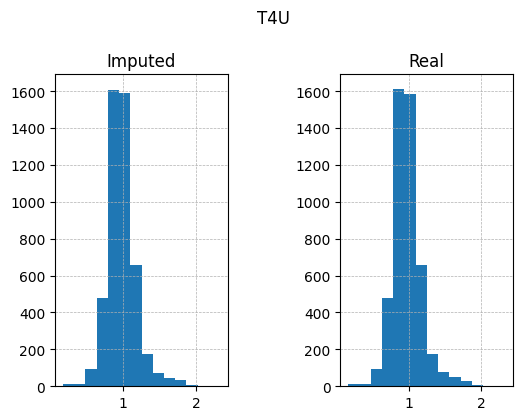

In [20]:
plot_col_histograms(train_df, imputed_train_df)

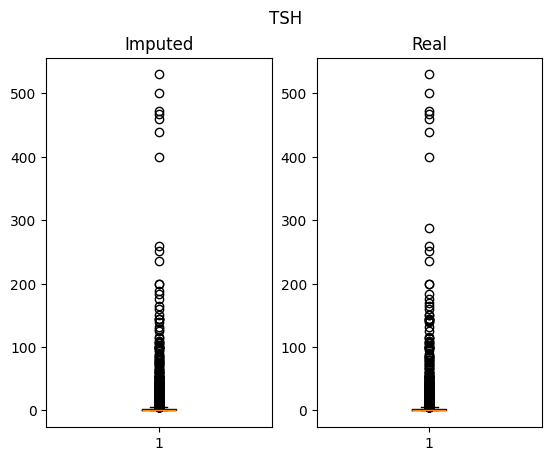

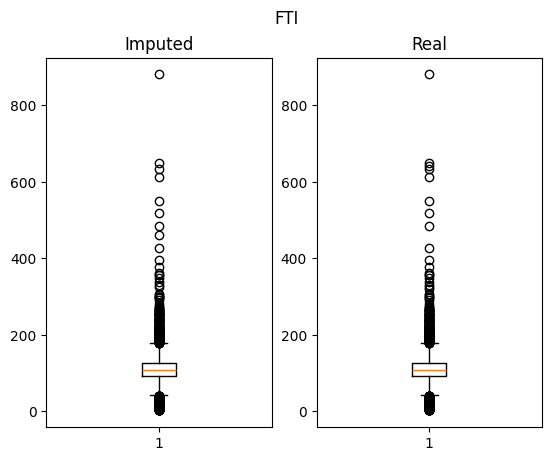

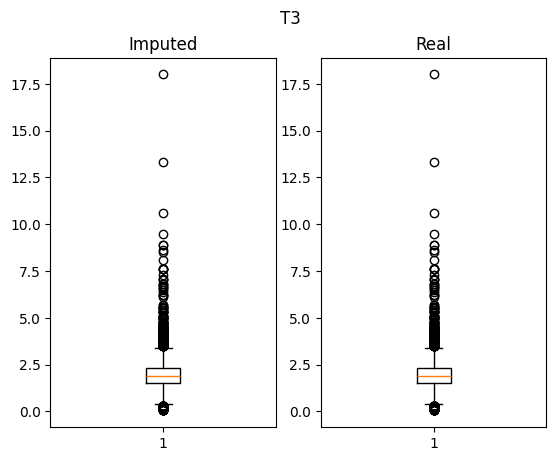

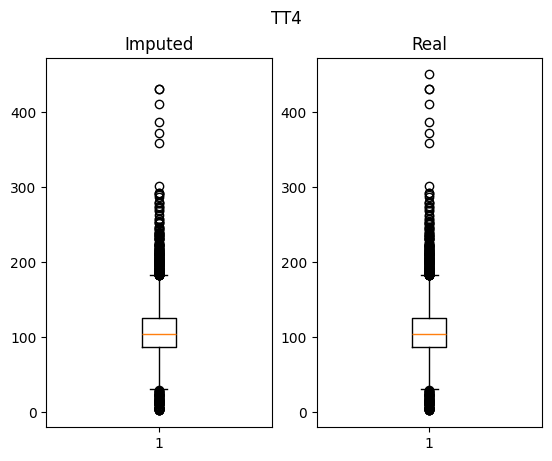

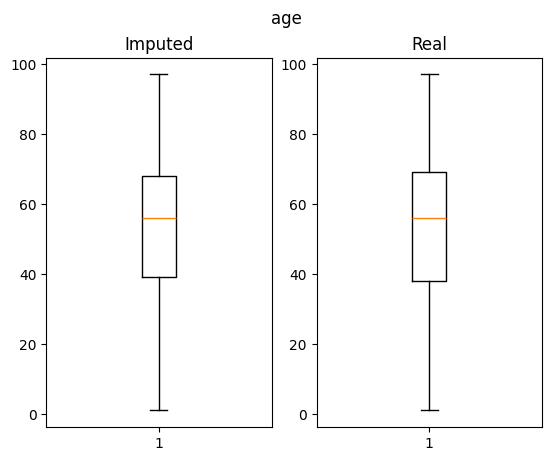

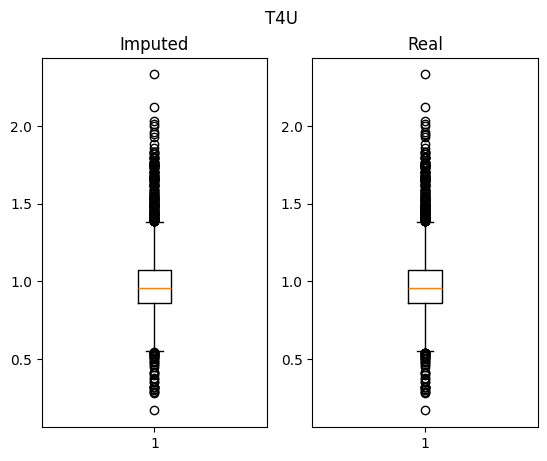

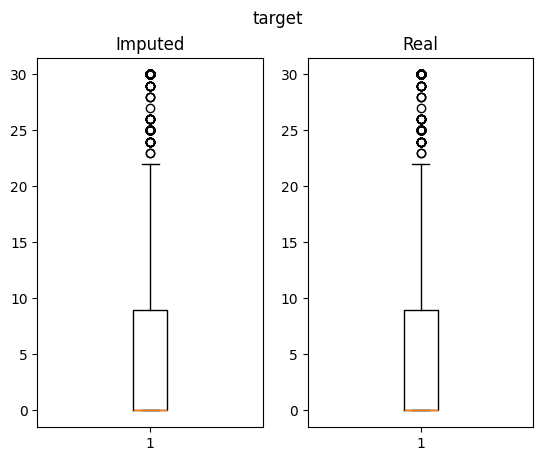

In [28]:
plot_col_boxplots(train_df[sel_qual_cols+['target']], imputed_train_df[sel_qual_cols+['target']])

In [29]:
imputed_means = np.concatenate([imputer.statistics_['col_modes'].flatten(), imputer.statistics_['col_means']])
imputed_means_df = pd.DataFrame([imputed_means], columns=sel_cat_cols+sel_qual_cols)
imputed_means_df = inverse_transform_categorical_columns(imputed_means_df, label_encoders)
imputed_means_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,f,f,f,f,f,f,f,F,-,f,f,f,4.779616,112.953276,1.971877,107.925752,53.279725,0.976549


### Results on test set (cross-validation)

In [30]:
X_test = test_missing_vals_df.to_numpy()
X_test_imputed = imputer.transform(X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


In [31]:
imputed_test_df = pd.DataFrame(X_test_imputed, columns=test_missing_vals_df.columns)
imputed_test_data_df = inverse_transform_categorical_columns(imputed_test_df.copy(), label_encoders)
imputed_test_data_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,f,t,f,f,f,f,f,M,-,f,f,f,4.400000,85.0,1.7,89.0,57.000000,1.0500
1,f,f,f,f,f,f,f,NaN,D,f,f,f,8.099999,482.0,3.5,134.0,42.000000,0.2800
2,f,f,f,f,f,f,f,M,-,f,f,f,0.200000,55.0,1.8,52.0,55.000000,0.9337
3,f,f,f,f,f,f,f,F,-,f,f,f,0.300000,122.0,2.8,118.0,42.000000,0.9700
4,f,f,f,f,f,f,f,F,R,f,f,f,2.800000,157.0,1.8,143.0,67.000000,0.9100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,f,f,f,f,f,f,f,M,-,f,f,f,1.300000,121.0,1.4,116.0,66.976667,0.9600
1192,f,f,f,f,f,f,f,F,-,f,f,f,2.900000,158.0,0.5,101.0,97.000000,0.6400
1193,f,f,f,f,f,f,f,M,-,f,f,f,0.970000,103.0,1.9,96.0,56.000000,0.9300
1194,f,f,f,f,f,f,f,M,-,f,f,f,0.720000,168.0,0.7,123.0,49.000000,0.7300


In [32]:
test_results = compare_imputations(test_df, imputed_test_df)
test_results

,Column,MSE,RMSE,MAE
0,pregnant,0.000836,0.028916,0.000836
1,thyroid_surgery,0.000836,0.028916,0.000836
2,sick,0.002508,0.050084,0.002508
3,goitre,0.000000,0.000000,0.000000
4,psych,0.004181,0.064658,0.004181
5,I131_treatment,0.000000,0.000000,0.000000
6,on_thyroxine,0.006689,0.081786,0.006689
7,sex,0.016722,0.129315,0.015050
8,target,0.505853,0.711233,0.032609
9,lithium,0.000836,0.028916,0.000836


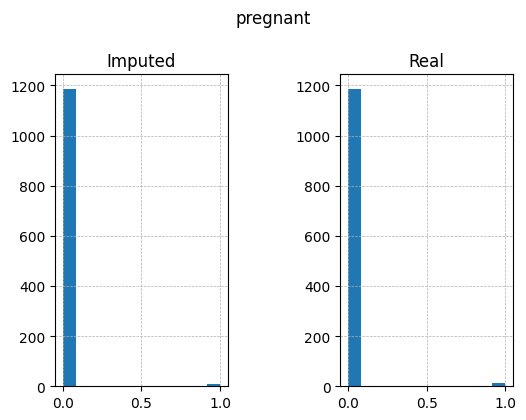

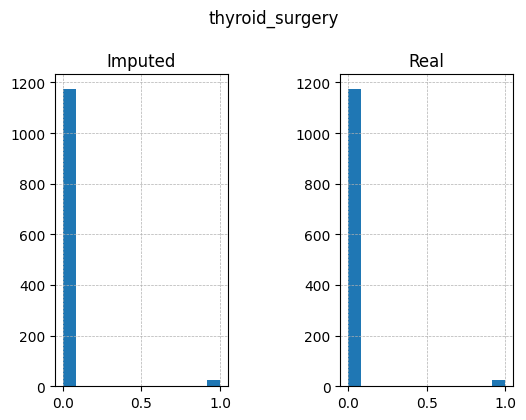

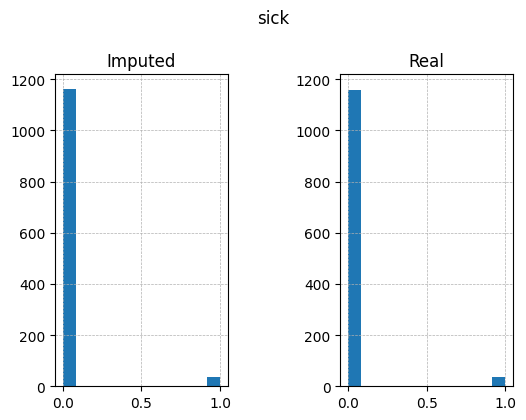

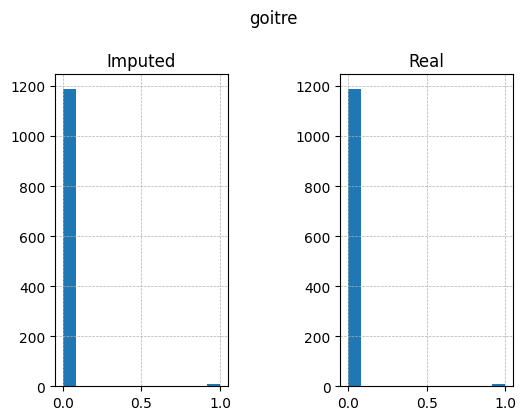

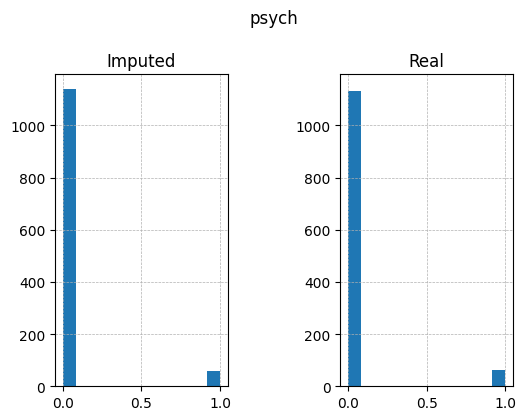

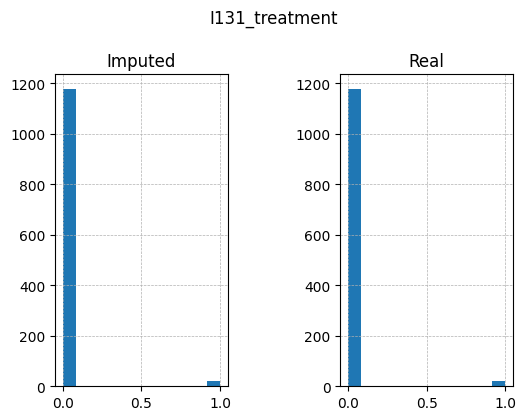

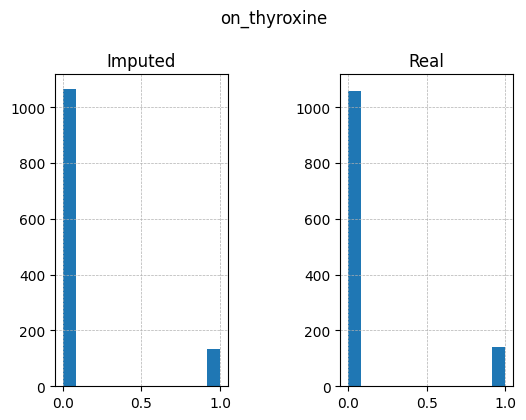

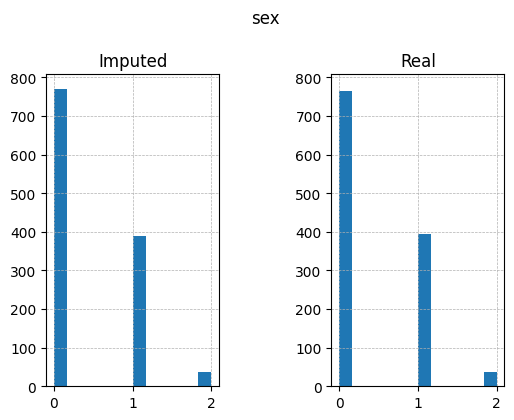

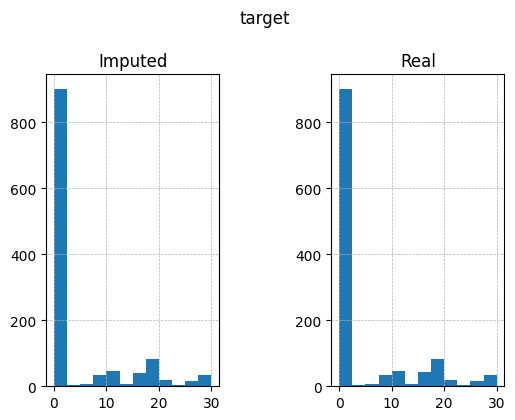

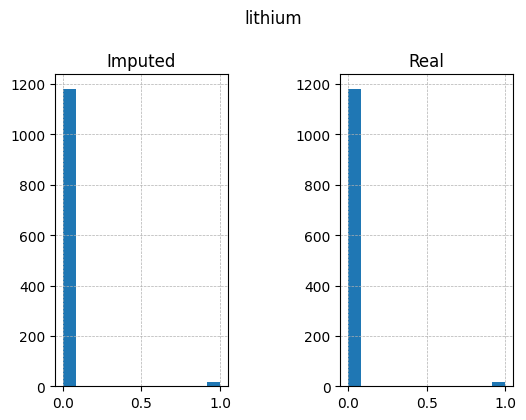

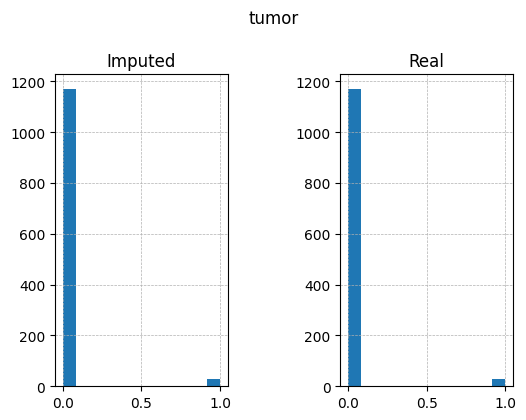

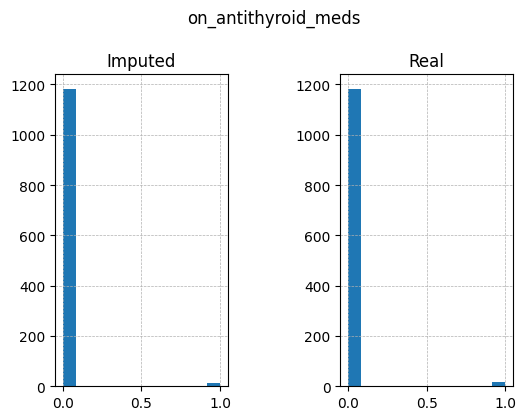

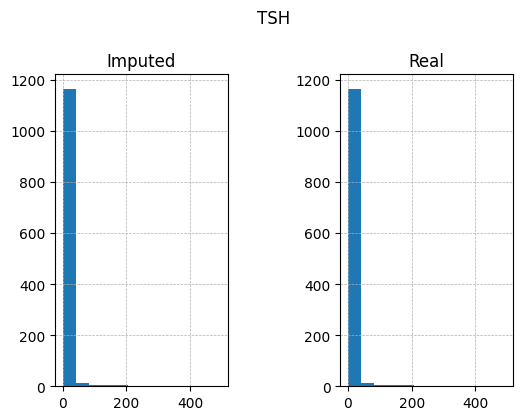

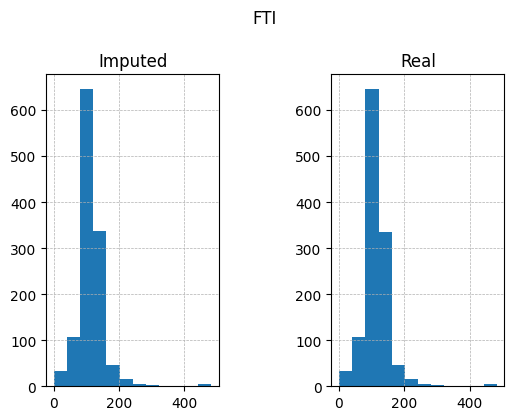

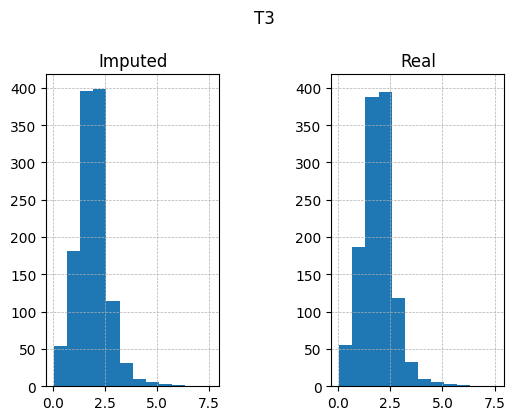

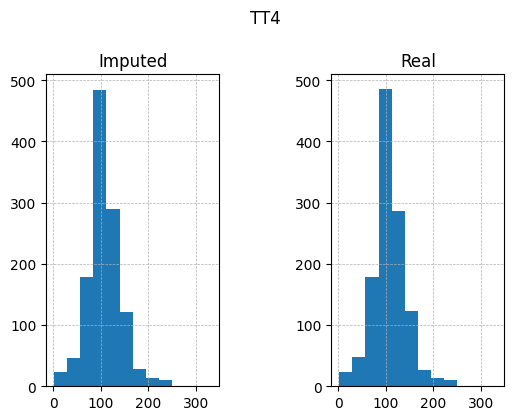

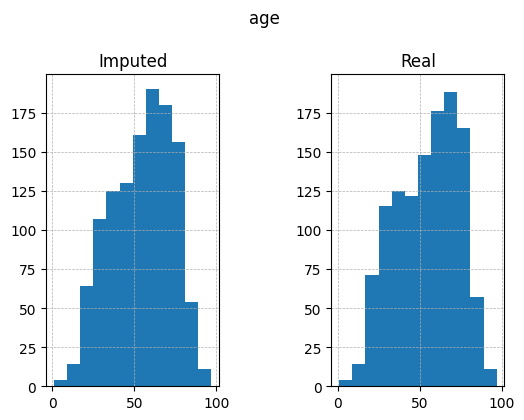

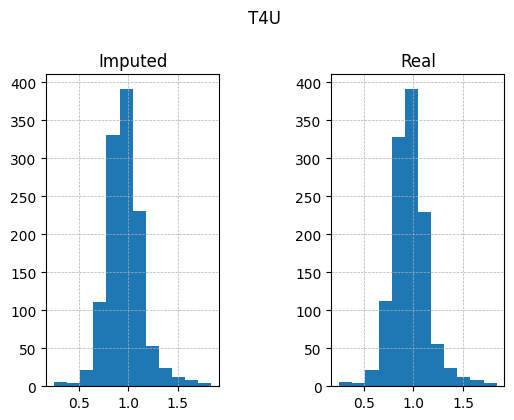

In [33]:
plot_col_histograms(test_df, imputed_test_df)

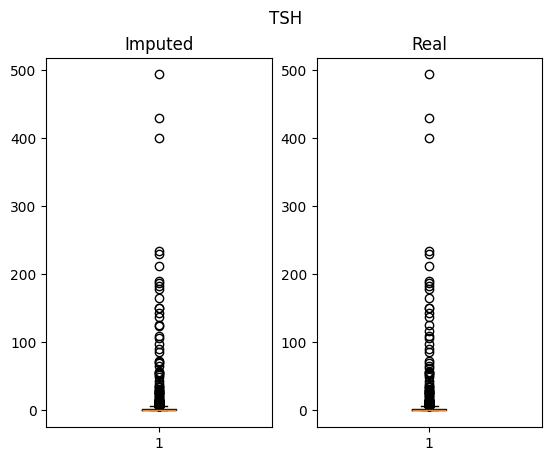

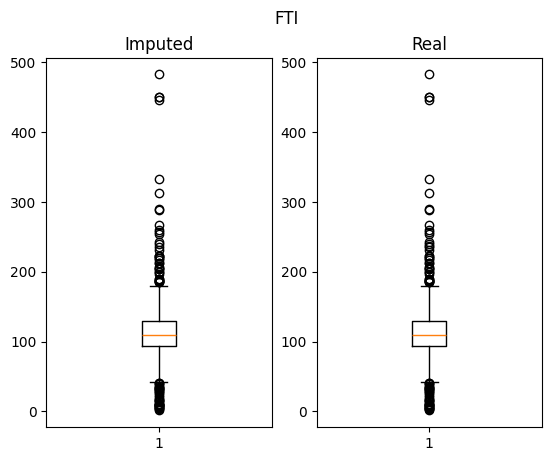

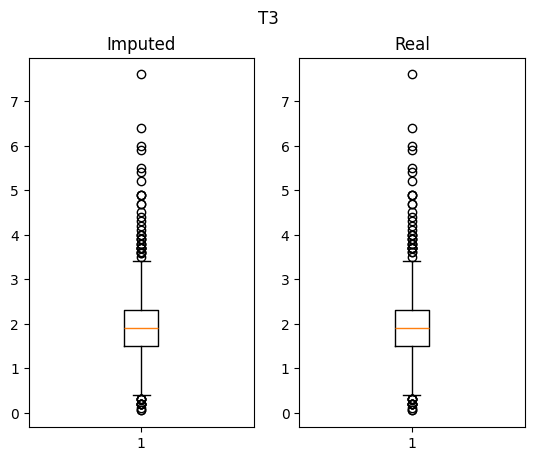

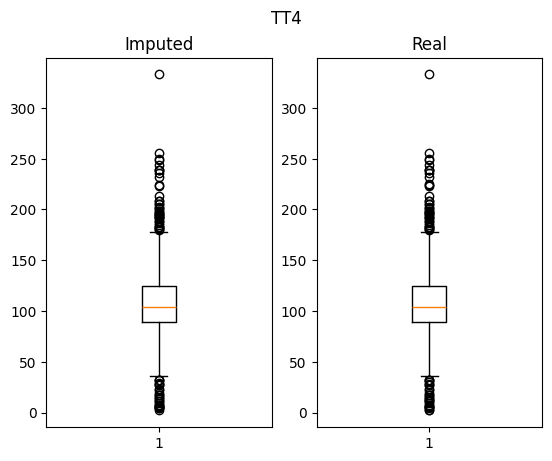

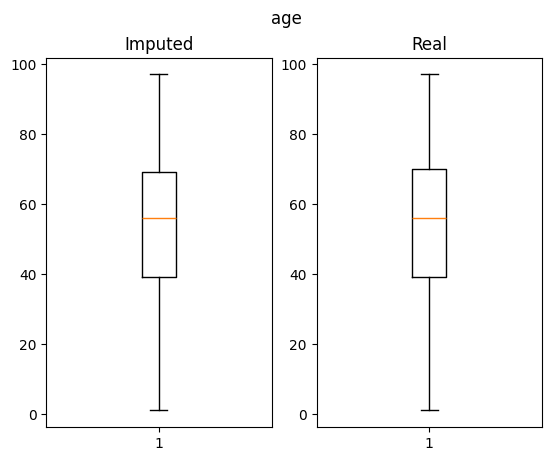

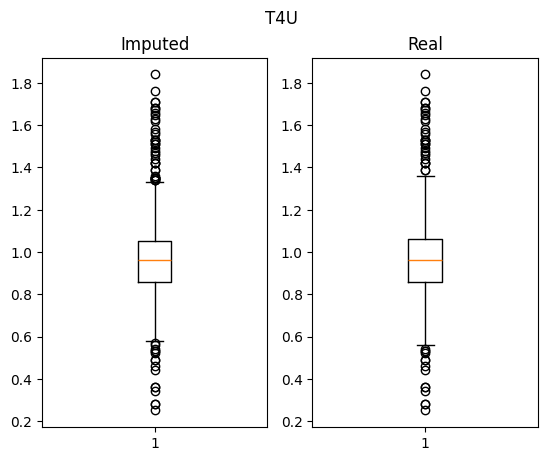

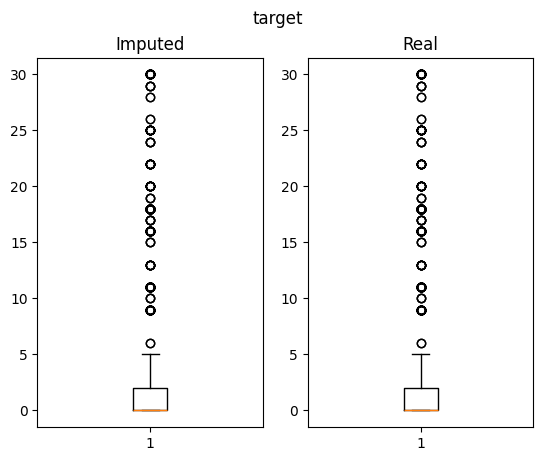

In [34]:
plot_col_boxplots(test_df[sel_qual_cols+['target']], imputed_test_df[sel_qual_cols+['target']])

## Imputation variant: fit-transform over train+test

In [35]:
missing_vals_df, missing_col_map, missing_vals_idxs = forget_random_col_per_sample(transformed_df, weight_map, random_generator)

In [36]:
all_imputer = MissForest(missing_values=np.NaN, n_estimators=300)
X_all = missing_vals_df.to_numpy()
X_all_imputed = all_imputer.fit_transform(X_all, cat_vars=get_column_indices(missing_vals_df, sel_cat_cols))

In [37]:
all_imputed_df = pd.DataFrame(X_all_imputed, columns=missing_vals_df.columns)
all_imputed_data_df = inverse_transform_categorical_columns(all_imputed_df.copy(), label_encoders)
all_imputed_data_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,f,f,f,f,f,f,f,F,-,f,f,f,1.50,85.0,2.4,90.0,36.0,1.06
1,f,f,f,f,f,f,f,F,-,f,f,f,1.20,96.0,2.3,104.0,40.0,1.08
2,f,f,f,f,f,f,f,F,-,f,f,f,5.90,105.0,2.1,88.0,40.0,0.84
3,f,f,f,f,f,f,f,F,-,f,f,f,0.05,95.0,2.4,107.0,77.0,1.13
4,f,f,f,f,f,f,f,F,-,f,f,f,0.05,106.0,2.1,93.0,51.0,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,f,f,f,f,f,f,f,M,-,f,f,f,0.73,94.0,1.8,85.0,65.0,0.90
5977,f,f,f,f,f,t,t,F,-,f,f,f,4.10,113.0,2.1,135.0,65.0,1.19
5978,f,f,t,f,f,f,f,F,F,f,f,f,53.00,39.0,1.0,49.0,74.0,1.25
5979,f,f,f,f,f,f,t,F,-,f,f,f,2.30,81.0,1.3,59.0,42.0,0.73


In [38]:
all_results = compare_imputations(transformed_df, all_imputed_df)
all_results

,Column,MSE,RMSE,MAE
0,pregnant,0.0,0.0,0.0
1,thyroid_surgery,0.0,0.0,0.0
2,sick,0.0,0.0,0.0
3,goitre,0.0,0.0,0.0
4,psych,0.0,0.0,0.0
5,I131_treatment,0.0,0.0,0.0
6,on_thyroxine,0.0,0.0,0.0
7,sex,0.0,0.0,0.0
8,target,0.0,0.0,0.0
9,lithium,0.0,0.0,0.0


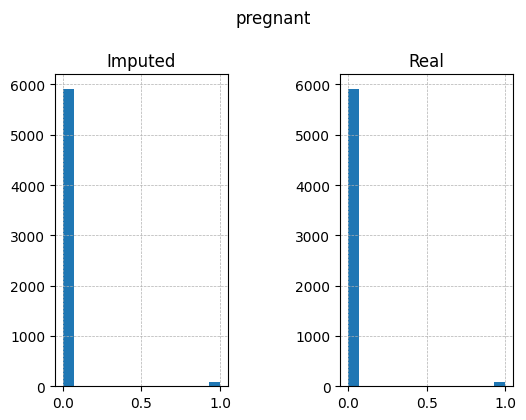

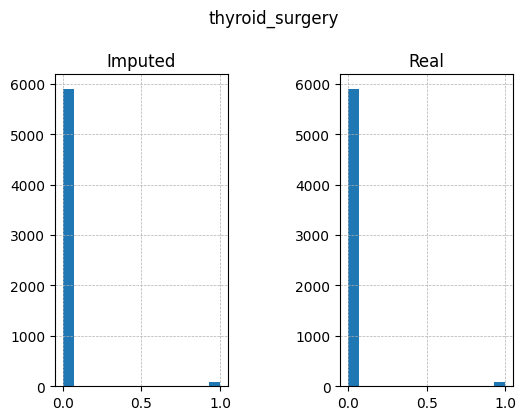

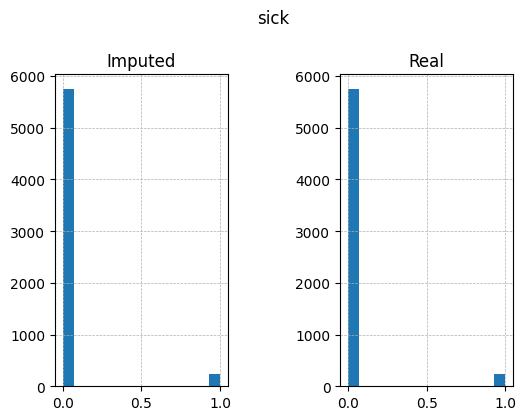

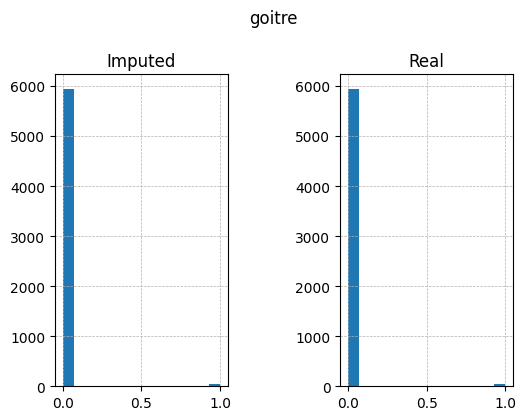

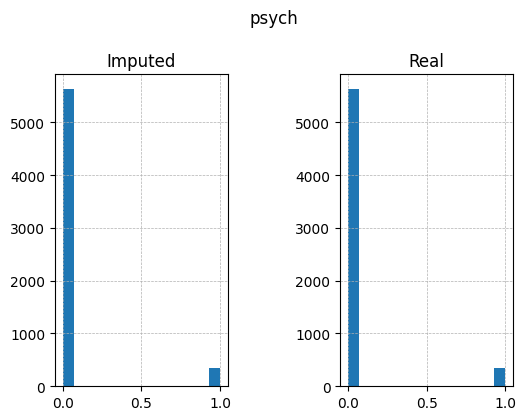

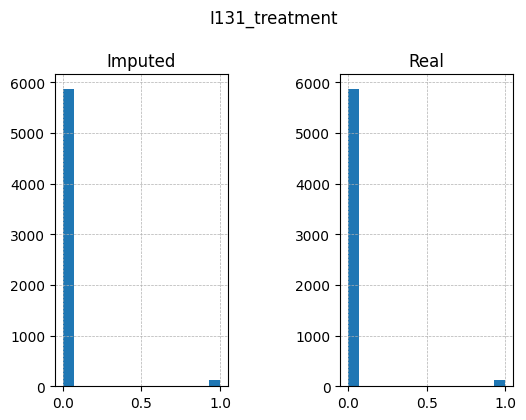

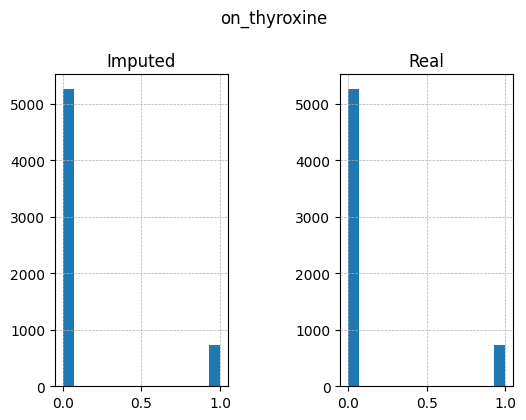

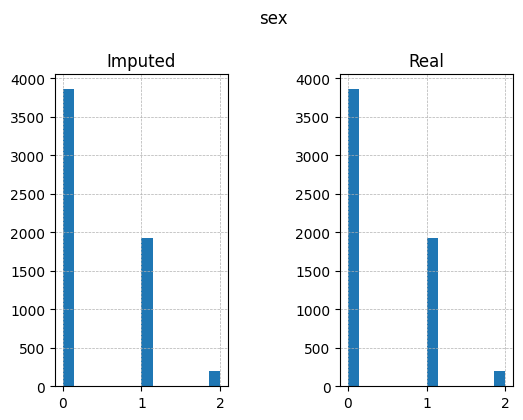

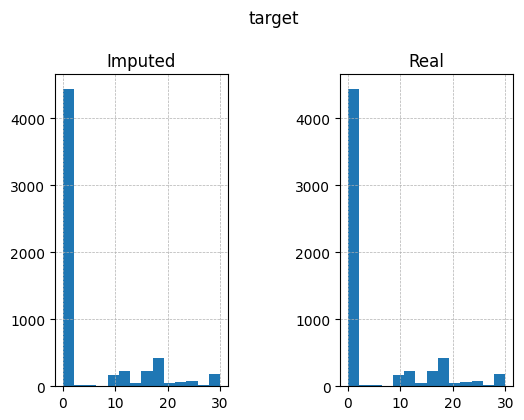

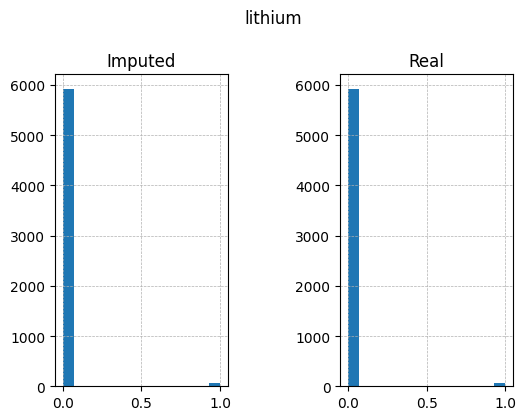

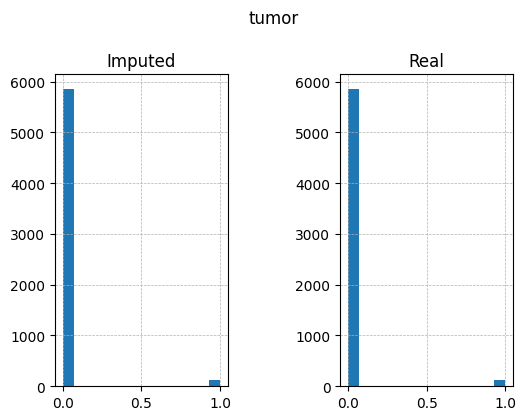

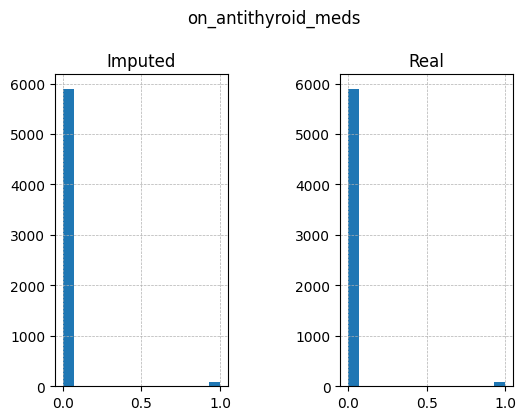

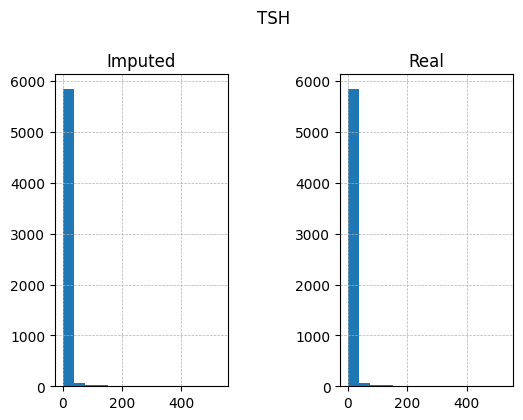

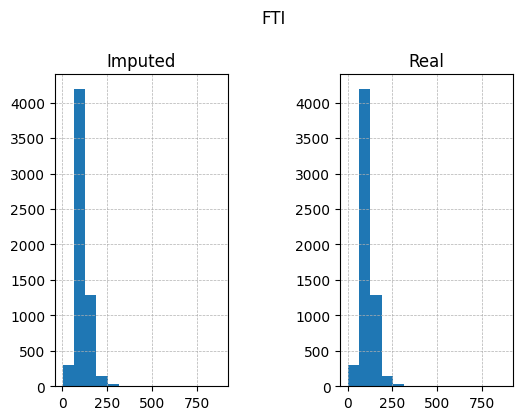

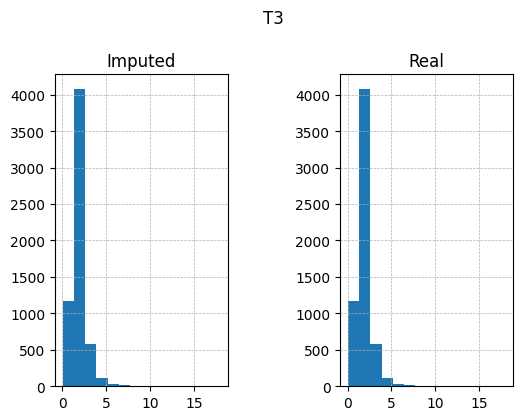

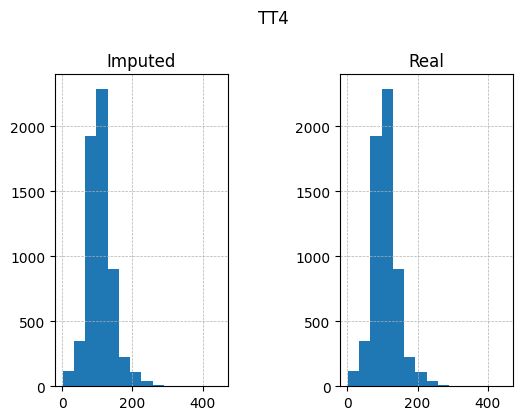

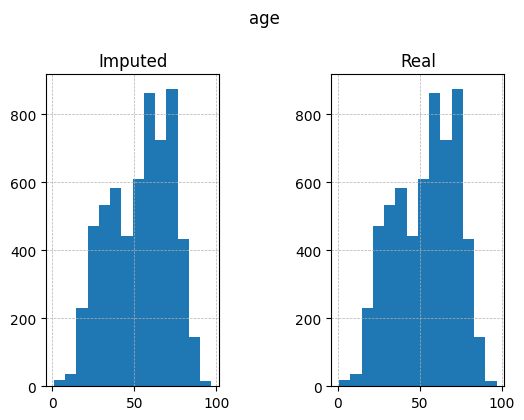

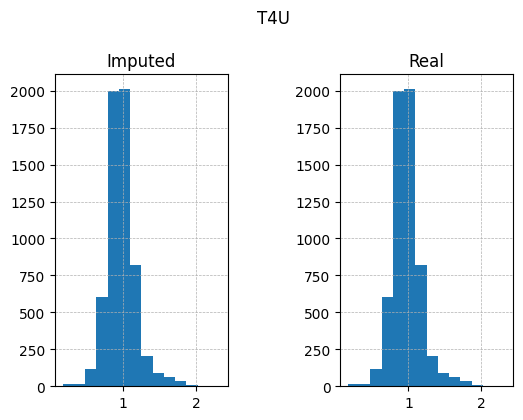

In [39]:
plot_col_histograms(transformed_df, all_imputed_df)

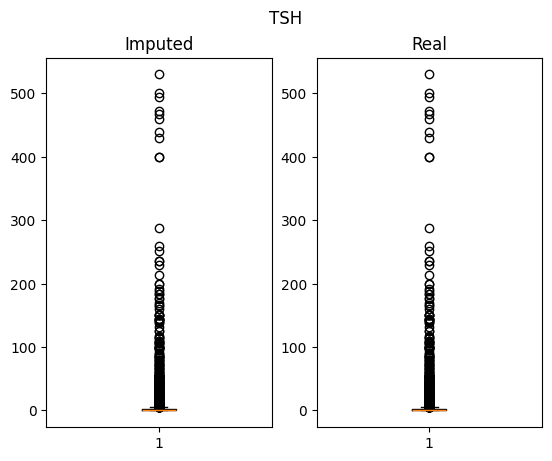

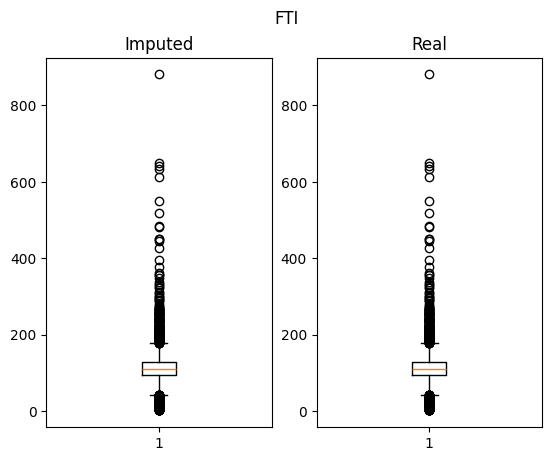

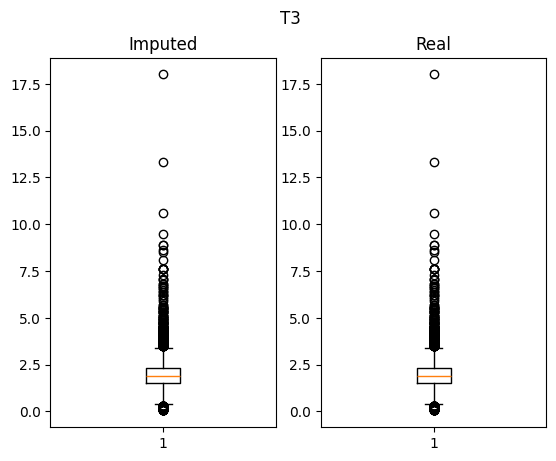

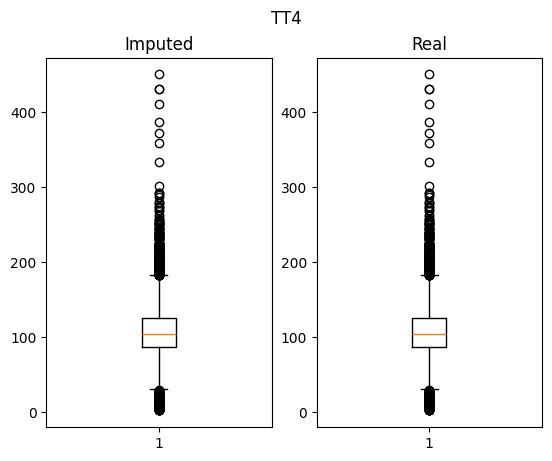

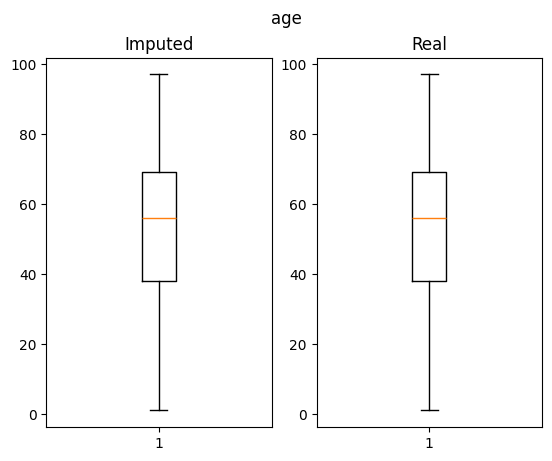

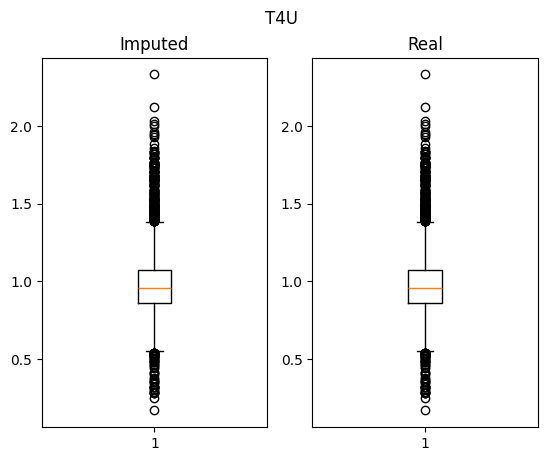

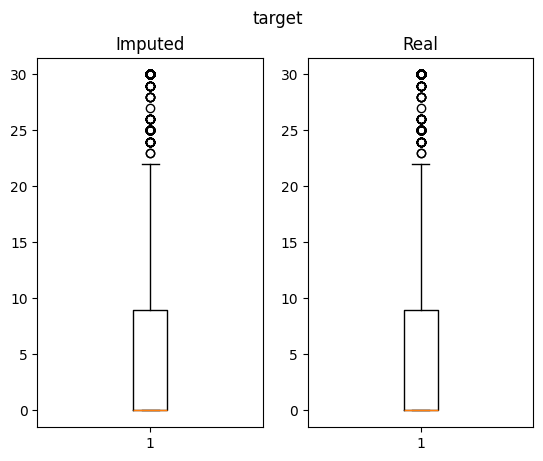

In [40]:
plot_col_boxplots(transformed_df[sel_qual_cols+['target']], all_imputed_df[sel_qual_cols+['target']])

In [41]:
all_imputed_means = np.concatenate([all_imputer.statistics_['col_modes'].flatten(), all_imputer.statistics_['col_means']])
all_imputed_means_df = pd.DataFrame([all_imputed_means], columns=sel_cat_cols+sel_qual_cols)
all_imputed_means_df = inverse_transform_categorical_columns(all_imputed_means_df, label_encoders)
all_imputed_means_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,f,f,f,f,f,f,f,F,-,f,f,f,5.205002,113.087617,1.957079,108.081134,53.459121,0.974465


### Impute initial df with missing values

In [42]:
X = transformed_nan_df.to_numpy()
X_imputed = all_imputer.transform(X)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [43]:
imputed_df = pd.DataFrame(X_imputed, columns=transformed_nan_df.columns)
imputed_data_df = inverse_transform_categorical_columns(imputed_df.copy(), label_encoders)
imputed_data_df

,pregnant,thyroid_surgery,sick,goitre,psych,I131_treatment,on_thyroxine,sex,target,lithium,tumor,on_antithyroid_meds,TSH,FTI,T3,TT4,age,T4U
0,f,f,f,f,f,f,f,F,-,f,f,f,0.300000,114.256667,2.077333,112.063333,29.0,0.980167
1,f,f,f,f,f,f,f,F,-,f,f,f,1.600000,127.726667,1.900000,128.000000,29.0,1.002200
2,f,f,f,f,f,f,f,F,-,f,f,f,1.435400,109.346667,2.145667,105.830000,41.0,0.967367
3,f,f,f,f,f,f,f,F,-,f,f,f,1.258883,129.123333,2.155667,127.756667,36.0,0.996067
4,f,f,f,f,f,f,f,F,S,f,f,f,1.962550,130.610000,2.176667,126.883333,32.0,0.971067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,f,f,f,f,f,f,f,M,-,f,f,f,2.666633,77.000000,1.849333,64.000000,56.0,0.830000
9164,f,f,f,f,f,f,f,M,-,f,f,f,1.487900,99.000000,2.086667,91.000000,22.0,0.920000
9165,f,f,f,f,f,f,f,M,I,f,f,f,1.708367,89.000000,3.011500,113.000000,69.0,1.270000
9166,f,f,f,f,f,f,f,F,-,f,f,f,1.833000,88.000000,1.676000,75.000000,47.0,0.850000
